# Comparison of Neural Models 2

## Feedforward Neural Network

Following an experiment to compare neural models, we discovered odd results showing that bag of words could outperform embeddings. This experiment attempts to tweak the embeddings to show the expected results under the assumption that the problem is not the amount of data. If the problem is the amount of data we will investigate this in another experiment.

Again, we will show Bag of Words results:

In [8]:
from scripts import training_helpers
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, MaxPooling2D
from tensorflow.keras.regularizers import l2
from pandas import DataFrame
from seaborn import boxplot
import matplotlib.pyplot as plt
import json

import gensim
import numpy as np

read_existing_embeddings = True

In [2]:
data_frame = training_helpers.get_data_frame()
raw_features = data_frame['review']
labels = [x for x in data_frame['deceptive']]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_features)
bow_features = tokenizer.texts_to_matrix(raw_features, mode='tfidf')

In [3]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

In [4]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(corpus_vocab_size,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_features, labels, cv=10, verbose=0)

Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 144us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 155us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 139us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 172us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 172us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 190us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 199us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 219us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 129us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 196us/step


And now we will get results for embeddings. This time I will use Word2Vec. Although this was not trained directly on words from our dataset, the Word2Vec has a higher dimensionality (making it harder to run on our machines) and so may show better results.

In [4]:
embedding_matrix = None
embedding_length = 0
if read_existing_embeddings:
  embedding_length=300
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  with open('data.json', 'r') as infile:
      data = json.load(infile)
      for i in range(len(data)):
          embedding_matrix[i] = np.array(data[i], dtype=np.float32)
else:
  word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin",
                                                                 binary=True)
  embedding_length = word_vectors.vector_size
    
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  for word, index in corpus_words.items():
    if word in word_vectors.vocab:
      embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

  with open('data.json', 'w') as outfile:
      json.dump(embedding_matrix.tolist(), outfile)

In [6]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=corpus_vocab_size),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

In [7]:
ff_wv_scores = run_cross_validate(get_ff_wv_model, bow_features, labels, cv=5)

Fitting with:  (1280, 9839) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 42s 47ms/step - loss: 1.0891 - acc: 0.5882 - val_loss: 1.2110 - val_acc: 0.6198
Epoch 2/12
896/896 [==============================] - 38s 43ms/step - loss: 1.2013 - acc: 0.7132 - val_loss: 1.3584 - val_acc: 0.6745
Epoch 3/12
896/896 [==============================] - 38s 42ms/step - loss: 1.2186 - acc: 0.7333 - val_loss: 1.4261 - val_acc: 0.7005
Epoch 4/12
896/896 [==============================] - 38s 42ms/step - loss: 1.2512 - acc: 0.7054 - val_loss: 1.3712 - val_acc: 0.6484
Epoch 5/12
320/320 [==============================] - 2s 7ms/step
Fitting with:  (1280, 9839) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 42s 47ms/step - loss: 0.9364 - acc: 0.5569 - val_loss: 1.0129 - val_acc: 0.6198
Epoch 2/12
896/896 [==============================] - 40s 44ms/step - loss: 1.1214 - a

In [8]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.875, 0.8625, 0.88125, 0.88125, 0.86875, 0.91875, 0.875, 0.8625, 0.88125, 0.8875]
Word vectors:  [0.628125, 0.709375, 0.665625, 0.703125, 0.659375]


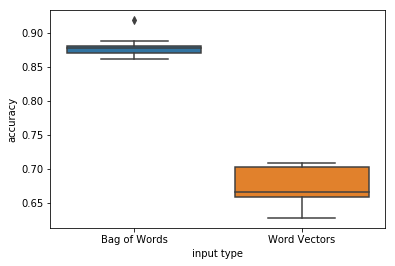

In [9]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

It looks like word vectors are doing better now! Although they should be more accurate than Bag of Words, unless this is an exceptional case. The next step here is to investigate how BoW and word vectors perform on more data, since a small amount of data is a case known to cause results like this. It is also very unlikely Bag of Words will perform as well on a large dataset.

## Convolutional Neural Network

Neural Networks were let down the most by word embeddings. Research has shown that word embeddings perform better than Bag of Words (Convolutional Neural Networks for Sentence Classification, Yoon Kim 2014). We will our convolutional network on Word2Vec embeddings to see if we obtain an improved accuracy:

In [11]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_features]), batches))
convolutional_data.shape

(1600, 1, 9839, 1)

In [13]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, corpus_vocab_size, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_bow_scores = run_cross_validate(get_conv_bow_model, convolutional_data, labels, cv=10, categorical=True)

Fitting with:  (1440, 1, 9839, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 9s 9ms/step - loss: 0.4324 - acc: 0.7885 - val_loss: 0.6778 - val_acc: 0.6513
Epoch 2/12
1007/1007 [==============================] - 8s 8ms/step - loss: 0.1362 - acc: 0.9543 - val_loss: 0.7423 - val_acc: 0.6536
Epoch 3/12
1007/1007 [==============================] - 10s 10ms/step - loss: 0.0747 - acc: 0.9791 - val_loss: 1.0627 - val_acc: 0.6028
Epoch 4/12
1007/1007 [==============================] - 10s 10ms/step - loss: 0.0461 - acc: 0.9891 - val_loss: 1.0094 - val_acc: 0.6189
Epoch 5/12
160/160 [==============================] - 1s 4ms/step
Fitting with:  (1440, 1, 9839, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 9s 9ms/step - loss: 0.4264 - acc: 0.7994 - val_loss: 0.6557 - val_acc: 0.6443
Epoch 2/12
1007/1007 [==============================] - 9s 9ms/s

160/160 [==============================] - 1s 3ms/step


In [32]:
reviews_words = [text_to_word_sequence(x) for x in raw_features]
max_review_len = max([len(x) for x in reviews_words])

vectorized_reviews = np.zeros((len(reviews_words), max_review_len, 300, 1))
for i, review in enumerate(reviews_words):
    for j, word in enumerate(review):
        vectorized_reviews[i][j] = 
        np.append(review_vectors, embedding_matrix[corpus_words[word]])
    np.append(vectorized_reviews, np.array(review_vectors))

In [24]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_first",
          input_shape=(1, 381, 300),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_first"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_wv_scores = run_cross_validate(get_conv_wv_model, vectorized_reviews, labels, cv=6, categorical=True)

Fitting with:  (1332,) labels (1332, 2)


ValueError: Error when checking input: expected conv2d_13_input to have 4 dimensions, but got array with shape (1332, 1)

In [34]:
vectorized_reviews.shape

(0,)